# Data Parameters
(Basically, this will be deleted, as we keep iterating on this until we can get the next checkpoint)

Input

- Frames: 5 in 5 out
- Target: 1 station (LA N. Main St.)
- Channels: AirNow, Wind U/V

Model
- Variation
```
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 5, 40, 40, 15)  │         9,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 5, 40, 40, 30)  │        48,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 5, 40, 40, 15)  │        12,165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 5, 40, 40, 1)   │           406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │        40,005 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 5, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘
```
- Adam 1e-4 LR, 1e-2 WD

Result
- ?

General Notes
- Trying out 5 frame out prediction with extra dense layer to allow communication between frames

In [1]:
# Data parameters
START_DATE = "2022-12-01-00"
END_DATE = "2024-12-01-00"

# Define bounding box
lat_bottom, lat_top = 33.5, 34.5
lon_bottom, lon_top = -118.75, -117.0
extent = (lon_bottom, lon_top, lat_bottom, lat_top)

# Input data shape
dim = 40
frames_per_sample = 5

print(f"{extent}")
print(f"Grid dimension: {dim}x{dim}")
print(f"Frames per sample: {frames_per_sample}")

(-118.75, -117.0, 33.5, 34.5)
Grid dimension: 40x40
Frames per sample: 5


# Data Ingestion and Preprocessing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
from datetime import datetime
import sys
sys.path.append("../..")
#from libs.sequence import PWWBPyDataset

In [3]:
X_test_files =  ["METAR_Wind_U_X_test.npy", "METAR_Wind_V_X_test.npy", "AirNow_PM25_X_test.npy"]
X_train_files = ["METAR_Wind_U_X_train.npy", "METAR_Wind_V_X_train.npy", "AirNow_PM25_X_train.npy"]
X_valid_files = ["METAR_Wind_U_X_valid.npy", "METAR_Wind_V_X_valid.npy", "AirNow_PM25_X_valid.npy"]

Y_test_files = "Y_test.npy"
Y_train_files = "Y_train.npy"
Y_valid_files = "Y_valid.npy"

In [4]:
''' y is not trimmed, can't use this method
BATCH_SIZE = 32
X_training_files_paths = [f"{path + file}" for file in X_train_files]
Y_training_files_paths = f"{path + Y_train_files}"
generator = PWWBPyDataset(X_training_files_paths, Y_training_files_paths, BATCH_SIZE, workers=8, use_multiprocessing=True)

history = seq.fit(
    generator,
    epochs=EPOCHS,
    validation_data=(X_valid_scaled, Y_valid),
    callbacks=callbacks
)
'''
path = "final_input_data/two_years_with_hrrr/"
X_train = np.stack([np.load(f"{path + file}") for file in X_train_files], axis=-1)
X_test = np.stack([np.load(f"{path + file}") for file in X_test_files], axis=-1)
X_valid = np.stack([np.load(f"{path + file}") for file in X_valid_files], axis=-1)

Y_train = np.load(f"{path + Y_train_files}")
Y_test = np.load(f"{path + Y_test_files}")
Y_valid = np.load(f"{path + Y_valid_files}")

In [5]:
# 5 frames in, one frame and one station out
# next frame = 0
# LA station = 4
Y_train = Y_train[:, :, [4]].copy()
Y_test = Y_test[:, :, [4]].copy()
Y_valid = Y_valid[:, :, [4]].copy()

# Model Definition

## Architecture

In [6]:
output_size = 1
input_shape = X_train.shape[1:] # (frames, height, width, channels)

print(
    f"X_train shape: {X_train.shape}\n"
    f"Y_train shape: {Y_train.shape}\n\n"
    
    f"X_test shape:  {X_test.shape}\n"
    f"Y_test shape:  {Y_test.shape}\n\n"

    f"X_valid shape: {X_valid.shape}\n"
    f"Y_valid shape: {Y_valid.shape}\n\n"

    f"Input shape:   {input_shape}\n"
    f"Output shape:  ({output_size})\n"
)

X_train shape: (12274, 5, 40, 40, 3)
Y_train shape: (12274, 5, 1)

X_test shape:  (2631, 5, 40, 40, 3)
Y_test shape:  (2631, 5, 1)

X_valid shape: (2630, 5, 40, 40, 3)
Y_valid shape: (2630, 5, 1)

Input shape:   (5, 40, 40, 3)
Output shape:  (1)



In [7]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv3D
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization, LayerNormalization
from keras.layers import Convolution2D, MaxPooling3D, Flatten, Reshape, GlobalAveragePooling2D
from keras.layers import TimeDistributed, Reshape
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import InputLayer

tf.keras.backend.set_image_data_format('channels_last')

seq = Sequential()

seq.add(
    InputLayer(shape=input_shape)
)

seq.add(
    ConvLSTM2D(
        filters=15, 
        kernel_size=(3, 3),
        padding='same', 
        return_sequences=True,
        #dropout=0.1,
        #recurrent_dropout=0.1,
        #kernel_regularizer=keras.regularizers.l2(0.1)
    )
)

seq.add(
    ConvLSTM2D(
        filters=30, 
        kernel_size=(3, 3),
        padding='same', 
        return_sequences=True,
        #dropout=0.1,
        #recurrent_dropout=0.1,
        #kernel_regularizer=keras.regularizers.l2(0.1)
    )
)

seq.add(
    Conv3D(
        filters=15, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same',
        #kernel_regularizer=keras.regularizers.l2(0.1)
    )
)

seq.add(
    Conv3D(
        filters=1, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same',
        #kernel_regularizer=keras.regularizers.l2(0.1)
    )
)

#seq.add(TimeDistributed(Flatten()))
seq.add(Flatten())

#seq.add(Dropout(rate=0.1))

seq.add(Dense(5, activation='relu'))

seq.add(Reshape((5, 1)))

seq.compile(
    loss='mean_absolute_error', 
    optimizer=keras.optimizers.Adam(learning_rate=0.0001, weight_decay=0.01)
)
seq.summary()

2025-07-07 00:04:59.617206: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-07 00:04:59.664412: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751871899.677259    8120 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751871899.682332    8120 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-07 00:04:59.733337: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 5, 40, 40, 15)  │         9,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 5, 40, 40, 30)  │        48,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 5, 40, 40, 15)  │        12,165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 5, 40, 40, 1)   │           406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │        40,005 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 5, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,076 (433.89 KB)

 Trainable params: 111,076 (433.89 KB)

 Non-trainable params: 0 (0.00 B)

## Callbacks

In [8]:
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import os
import time

# tensorboard gradient logging callback
# at the end of an epoch, pass in a sample batch and calculate the gradients
class GradientLogger(tf.keras.callbacks.Callback):
    def __init__(self, log_dir, data_sample):
        super().__init__()
        self.writer = tf.summary.create_file_writer(log_dir)
        self.data_sample = data_sample  # A batch of (x, y) from your training data

    def on_epoch_end(self, epoch, logs=None):
        # log gradients
        x, y = self.data_sample

        with tf.GradientTape() as tape:
            loss = self.model.compute_loss(
                y=y, 
                y_pred=self.model(x, training=True)
            )

        gradients = tape.gradient(loss, self.model.trainable_weights)
        grad_norm = tf.linalg.global_norm(gradients)

        # plot gradients
        with self.writer.as_default():
            tf.summary.scalar("gradient_norm/global", grad_norm, step=epoch)
            
            for weight, grad in zip(self.model.trainable_weights, gradients):
                if grad is not None:
                    tf.summary.histogram(f"gradients/{weight.name}", grad, step=epoch)
            self.writer.flush()

# tensorboard callback setup
def get_run_logdir(
    root_logdir, 
    run_id=time.strftime("run_%Y_%m_%d-%H_%M_%S")
):
    return os.path.join(root_logdir, run_id)
    
run_logdir = get_run_logdir(
    root_logdir=os.path.join(os.curdir, "my_logs"),
    run_id="default"
)
tensorboard_callback = TensorBoard(run_logdir, histogram_freq=1)
#gradient_logging_callback = GradientLogger(run_logdir, data_sample=(X_test_scaled[:32], Y_test[:32]))

# model checkpoint callback setup
model_checkpoint_file = 'experiment_output/basic_experiments/model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=model_checkpoint_file,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

# lr scheduling callback setup
lr_scheduling_callback = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
)

# early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=20,
    restore_best_weights=True,
)

# define list of callbacks we're gonna use
callbacks = [
    early_stopping_callback,
    model_checkpoint_callback,
    #lr_scheduling_callback,
    #tensorboard_callback,
    #gradient_logging_callback
]

## Training

In [9]:
history = seq.fit(
    X_train,
    Y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_valid, Y_valid),
    callbacks=callbacks
)

Epoch 1/200


I0000 00:00:1751871905.215472    8202 service.cc:148] XLA service 0x5fba66888140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751871905.215492    8202 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-07-07 00:05:05.294642: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1751871905.577844    8202 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-07-07 00:05:06.114772: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[32,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backen

  3/384 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - loss: 10.2876

I0000 00:00:1751871908.183876    8202 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


383/384 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 7.0437

2025-07-07 00:05:29.099316: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[18,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[18,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[18,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-07-07 00:05:29.223823: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[18,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[18,3,40,40]{3,2,1,0}, f32[15,3,3,3]{3,2,1,0}, f32[15]{0}, f32[18,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01-

384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 7.0409

2025-07-07 00:05:33.287208: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[6,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[6,3,40,40]{3,2,1,0}, f32[15,3,3,3]{3,2,1,0}, f32[15]{0}, f32[6,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-07-07 00:05:33.329146: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[6,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[6,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[6,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01,

384/384 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - loss: 7.0380 - val_loss: 5.9034
Epoch 2/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - loss: 5.1043 - val_loss: 5.5764
Epoch 3/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - loss: 4.8105 - val_loss: 5.4692
Epoch 4/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - loss: 4.7735 - val_loss: 5.3465
Epoch 5/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - loss: 4.6997 - val_loss: 5.4346
Epoch 6/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - loss: 4.5802 - val_loss: 5.2876
Epoch 7/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - loss: 4.5234 - val_loss: 5.3121
Epoch 8/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - loss: 4.4956 - val_loss: 5.1876
Epoch 9/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 4.0268 - val_loss: 3.0184
Epoch 10/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 2.9687 - val_loss: 3.0731
Epoch 11/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 2.8498 - val_loss: 2.9325
Epoch 12/200
384/384 ━━━━━━━━━━

# Model Evaluation


Evaluating model


2025-07-07 00:26:39.341242: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[7,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,3,40,40]{3,2,1,0}, f32[15,3,3,3]{3,2,1,0}, f32[15]{0}, f32[7,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-07-07 00:26:39.382191: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[7,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[7,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01,

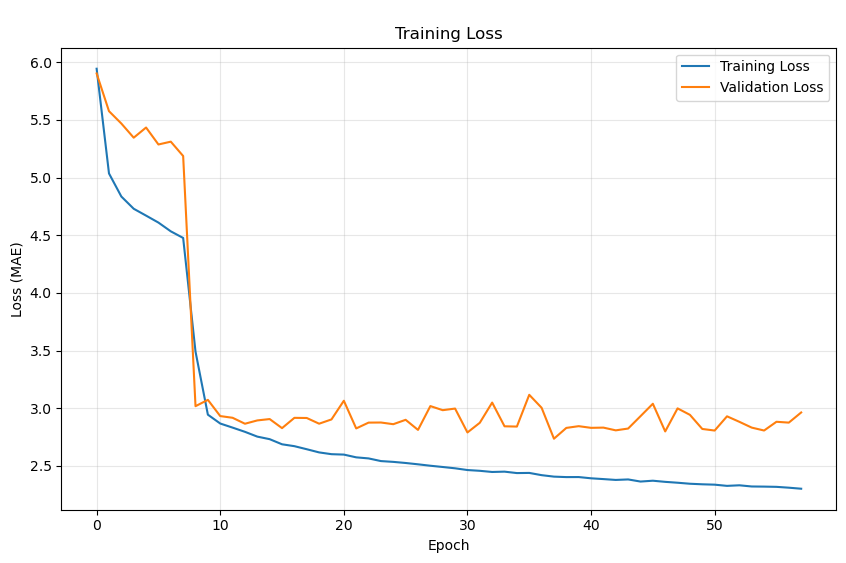

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime

# Evaluate model
print(f"\nEvaluating model")
#model = keras.saving.load_model(model_checkpoint_file)
y_pred = seq.predict(X_test, verbose=0)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title(f'\nTraining Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.grid(True, alpha=0.3)
plt.show()

In [11]:
import sys
sys.path.append('../..')
from libs.plotting import *
import pandas as pd

results = [
    [
        rmse(Y_test[1:], Y_test[:-1]), 
        rmse(y_pred, Y_test),
        rmse(y_pred[1:], Y_test[:-1]),
    ],
    [
        nrmse(Y_test[1:], Y_test[:-1]),
        nrmse(y_pred, Y_test),        
        nrmse(y_pred[1:], Y_test[:-1]),

    ],
    [        
        mae(Y_test[1:], Y_test[:-1]),
        mae(y_pred, Y_test),
        mae(y_pred[1:], Y_test[:-1]),
    ],
    [
        r2_score(Y_test[:-1], Y_test[1:]),
        r2_score(Y_test, y_pred),
        r2_score(Y_test[:-1], y_pred[1:]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'R2']
)
display(df)

,Baseline Error,Model Error,Model Error Shifted
RMSE,2.338691,3.598653,3.147881
NRMSE,16.806614,25.867721,22.621726
MAE,1.462471,2.467873,2.117460
R2,0.867793,0.687102,0.760477


In [12]:
# first-frame error
results = [
    [
        rmse(Y_test[1:, 0], Y_test[:-1, 0]), 
        rmse(y_pred[:, 0], Y_test[:, 0]),
        rmse(y_pred[1:, 0], Y_test[:-1, 0]),
    ],
    [
        nrmse(Y_test[1:, 0], Y_test[:-1, 0]),
        nrmse(y_pred[:, 0], Y_test[:, 0]),        
        nrmse(y_pred[1:, 0], Y_test[:-1, 0]),

    ],
    [        
        mae(Y_test[1:, 0], Y_test[:-1, 0]),
        mae(y_pred[:, 0], Y_test[:, 0]),
        mae(y_pred[1:, 0], Y_test[:-1, 0]),
    ],
    [
        r2_score(Y_test[:-1, 0], Y_test[1:, 0]),
        r2_score(Y_test[:, 0], y_pred[:, 0]),
        r2_score(Y_test[:-1, 0], y_pred[1:, 0]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'R2']
)
display(df)

,Baseline Error,Model Error,Model Error Shifted
RMSE,2.338641,2.319053,1.773114
NRMSE,16.802139,16.665739,12.739072
MAE,1.462357,1.532455,1.135686
R2,0.867632,0.869899,0.923909


In [13]:
# clean up dead sensors
dead_sens = np.where(Y_test == 0)
print(len(dead_sens[0]))

cleaned_test = np.delete(Y_test, dead_sens, 0)
cleaned_pred = np.delete(y_pred, dead_sens, 0)
print(cleaned_test.shape)
print(cleaned_pred.shape)

results = [
    [
        rmse(cleaned_test[1:], cleaned_test[:-1]), 
        rmse(cleaned_pred, cleaned_test),
        rmse(cleaned_pred[1:], cleaned_test[:-1]),
    ],
    [
        nrmse(cleaned_test[1:], cleaned_test[:-1]),
        nrmse(cleaned_pred, cleaned_test),        
        nrmse(cleaned_pred[1:], cleaned_test[:-1]),

    ],
    [        
        mae(cleaned_test[1:], cleaned_test[:-1]),
        mae(cleaned_pred, cleaned_test),
        mae(cleaned_pred[1:], cleaned_test[:-1]),
    ],
    [
        r2_score(cleaned_test[:-1], cleaned_test[1:]),
        r2_score(cleaned_test, cleaned_pred),
        r2_score(cleaned_test[:-1], cleaned_pred[1:]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'R2']
)
display(df)

75
(2591, 5, 1)
(2591, 5, 1)


,Baseline Error,Model Error,Model Error Shifted
RMSE,2.006907,3.396791,2.932548
NRMSE,14.351496,24.296942,20.970809
MAE,1.414965,2.398799,2.049696
R2,0.899593,0.712499,0.785613


In [18]:
results = [
    [
        rmse(cleaned_test[1:, 0], cleaned_test[:-1, 0]), 
        rmse(cleaned_pred[:, 0], cleaned_test[:, 0]),
        rmse(cleaned_pred[1:, 0], cleaned_test[:-1, 0]),
    ],
    [
        nrmse(cleaned_test[1:, 0], cleaned_test[:-1, 0]),
        nrmse(cleaned_pred[:, 0], cleaned_test[:, 0]),        
        nrmse(cleaned_pred[1:, 0], cleaned_test[:-1, 0]),

    ],
    [        
        mae(cleaned_test[1:, 0], cleaned_test[:-1, 0]),
        mae(cleaned_pred[:, 0], cleaned_test[:, 0]),
        mae(cleaned_pred[1:, 0], cleaned_test[:-1, 0]),
    ],
    [
        r2_score(cleaned_test[:-1, 0], cleaned_test[1:, 0]),
        r2_score(cleaned_test[:, 0], cleaned_pred[:, 0]),
        r2_score(cleaned_test[:-1, 0], cleaned_pred[1:, 0]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'R2']
)
display(df)

,Baseline Error,Model Error,Model Error Shifted
RMSE,2.027686,2.012211,1.485316
NRMSE,14.498985,14.392138,10.620767
MAE,1.420425,1.464043,1.079796
R2,0.897885,0.899488,0.945207


📊 TEMPORAL DEGRADATION ANALYSIS
This measures how ConvLSTM prediction accuracy degrades as we predict further into the future.
Later time steps are inherently harder to predict due to error accumulation.



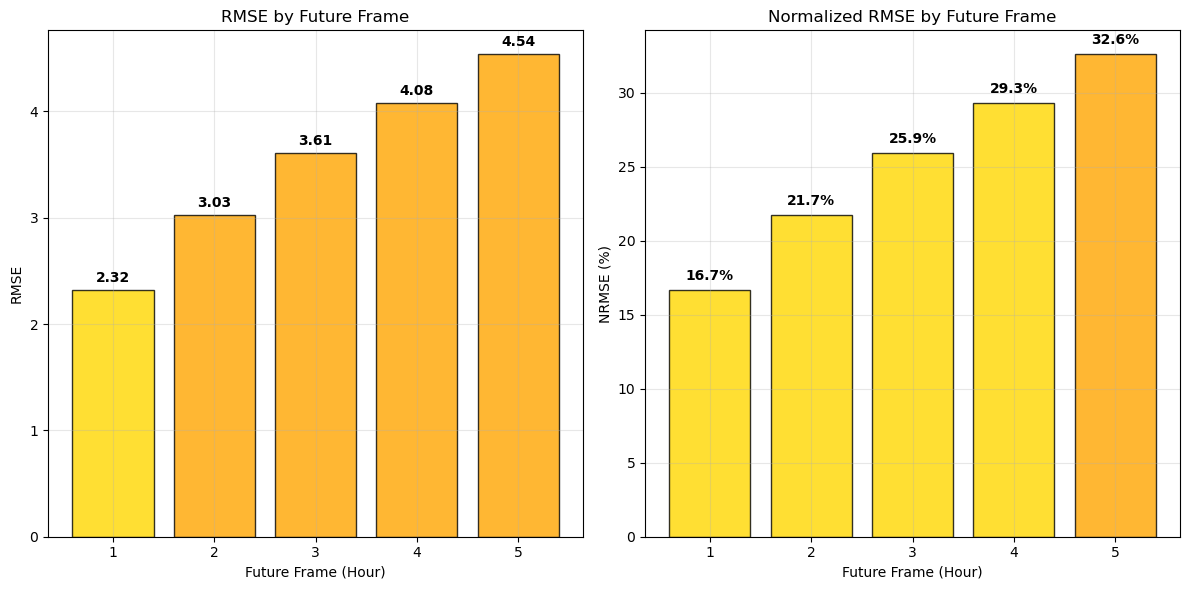


📊 FRAME-BY-FRAME RMSE SUMMARY:
Hour 1: RMSE = 2.319 (16.7%)
Hour 2: RMSE = 3.026 (21.7%)
Hour 3: RMSE = 3.607 (25.9%)
Hour 4: RMSE = 4.080 (29.3%)
Hour 5: RMSE = 4.535 (32.6%)
📋 DETAILED CONVLSTM PERFORMANCE BREAKDOWN
This section provides comprehensive metrics for each prediction horizon and monitoring station.
Essential for identifying specific model weaknesses and guiding improvements.

📋 DETAILED FRAME-BY-FRAME STATISTICS

🕐 HOUR 1 ANALYSIS
────────────────────────────────────────────────────────────────────────────────────────────────────
┌─ OVERALL PERFORMANCE ──────────────────────────────────────────────────────────┐
│ RMSE:  2.319 (16.7%)   │   MAE:  1.532   │   R²:  0.870              │
└────────────────────────────────────────────────────────────────────────────────┘

📍 BY SENSOR LOCATION:
────────────────────────────────────────────────────────────────────────────────────────────────────
Location                 │RMSE   │%     │MAE    │R²     │Actual │Pred  
──────────────

In [14]:
sensor_names = ['Los Angeles - N. Main Street']
plot_frame_by_frame_rmse(y_pred, Y_test)
print_detailed_frame_stats(y_pred, Y_test, sensor_names)

# Plots

## Snapshot plots - first frame

In [15]:
best_week = float('inf')
worst_week = float('-inf')
best_idx, worst_idx = 0, 0

worst_week_cleaned = float('-inf')
worst_idx_cleaned = 0
for i in range(len(y_pred) - 168):
    err = nrmse(y_pred[i:i+168, 0], Y_test[i:i+168, 0])
    if err < best_week:
        best_week = err
        best_idx = i
    if err > worst_week:
        worst_week = err
        worst_idx = i

    cleaned_err = nrmse(cleaned_pred[i:i+168], cleaned_test[i:i+168])
    if cleaned_err > worst_week_cleaned:
        worst_week_cleaned = cleaned_err
        worst_idx_cleaned = i

print(f"Best week {best_idx} to {best_idx+168} at {best_week:.2f}%")
print(f"Worst week {worst_idx} to {worst_idx+168} at {worst_week:.2f}%")
print(f"Worst week cleaned {worst_idx_cleaned} to {worst_idx_cleaned+168} at {worst_week_cleaned:.2f}%")

Best week 54 to 222 at 9.93%
Worst week 1525 to 1693 at 26.07%
Worst week cleaned 2462 to 2630 at 32.83%


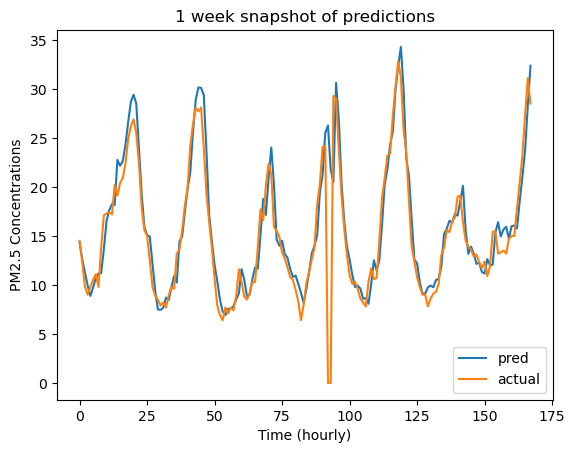

In [16]:
plt.plot(y_pred[1000:1168, 0], label='pred')
plt.plot(Y_test[1000:1168, 0], label='actual')
plt.xlabel("Time (hourly)")
plt.ylabel("PM2.5 Concentrations")
plt.title("1 week snapshot of predictions")
plt.legend(loc="lower right")

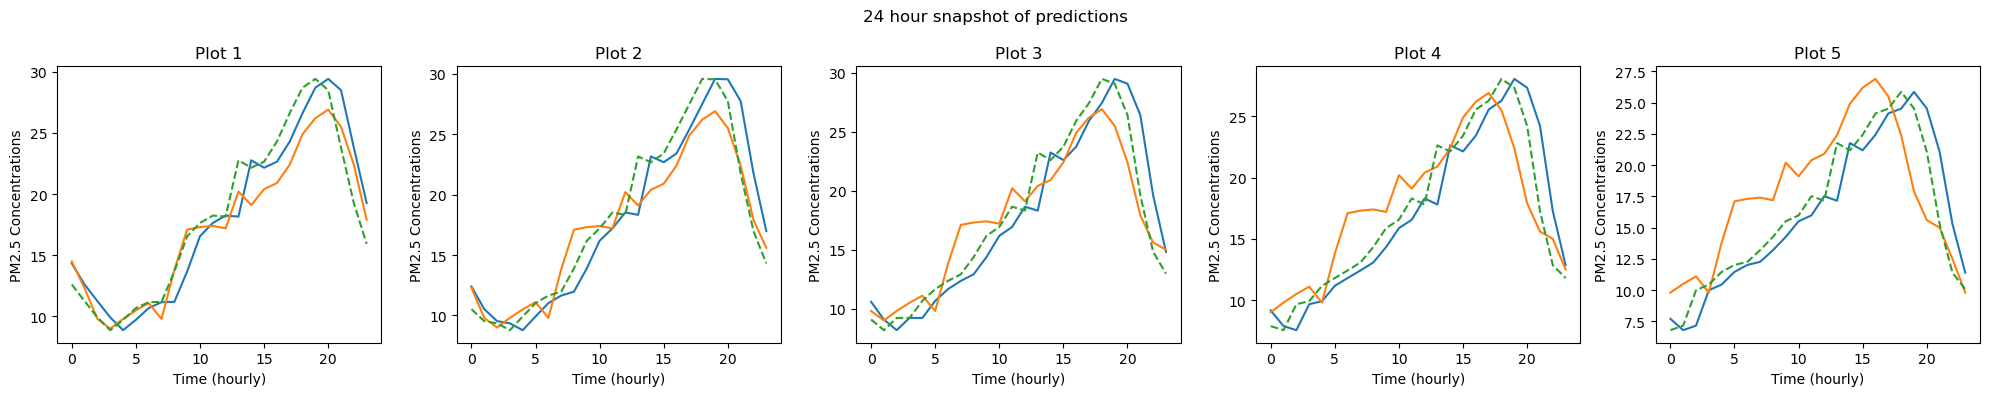

In [20]:
# plot 24 hours of data for each prediction
fig, axes = plt.subplots(1, 5, figsize=(20, 4))  # 1 row, 5 columns
fig.suptitle('24 hour snapshot of predictions')

# not sure if the logic here is right?
for i in range(5):
    axes[i].plot(y_pred[1000:1024, i], label='pred')
    axes[i].plot(Y_test[1000:1024, i], label='actual')
    axes[i].plot(y_pred[1001:1025, i], linestyle='--', label='pred offset')
    axes[i].set_title(f'Plot {i+1}')
    axes[i].set_xlabel('Time (hourly)')
    axes[i].set_ylabel('PM2.5 Concentrations')

# Tidy up the layout
plt.tight_layout()
plt.show()

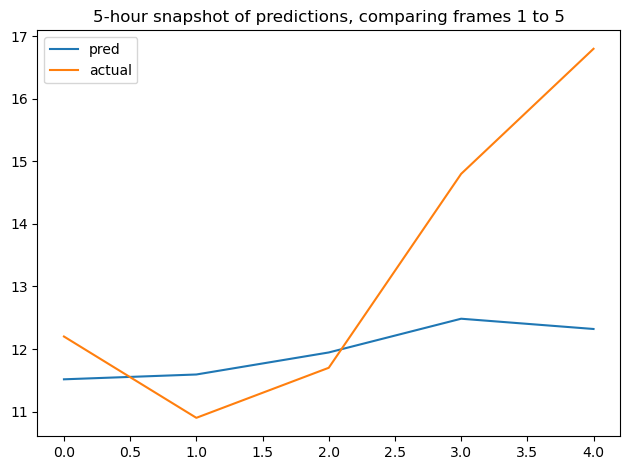

In [45]:
# compare past 5 with next 5
plt.plot(y_pred[best_idx, :], label='pred')
plt.plot(Y_test[best_idx, :], label='actual')
plt.title("5-hour snapshot of predictions, comparing frames 1 to 5")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

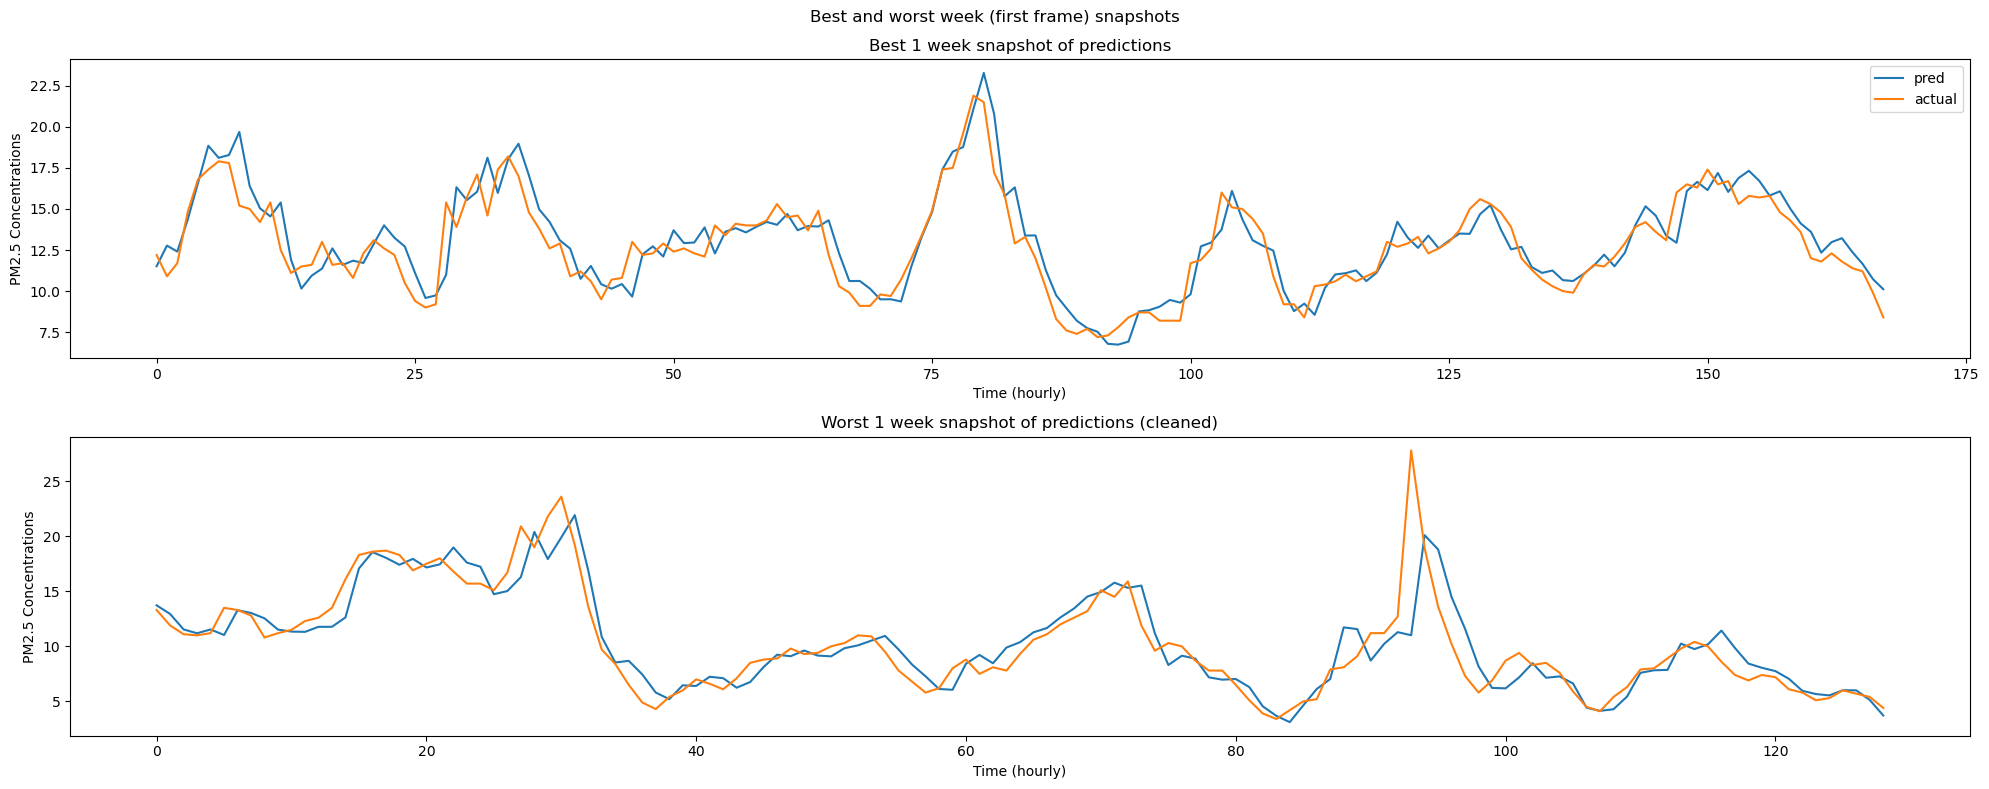

In [43]:
fig, axes = plt.subplots(2, 1, figsize=(20, 8))
fig.suptitle('Best and worst week (first frame) snapshots')

# best week
axes[0].plot(y_pred[best_idx:best_idx+168, 0], label='pred')
axes[0].plot(Y_test[best_idx:best_idx+168, 0], label='actual')
axes[0].set_xlabel("Time (hourly)")
axes[0].set_ylabel("PM2.5 Concentrations")
axes[0].set_title("Best 1 week snapshot of predictions")
axes[0].legend(loc="upper right")

# worst week (cleaned)
axes[1].plot(cleaned_pred[worst_idx_cleaned:worst_idx_cleaned+168, 0], label='pred')
axes[1].plot(cleaned_test[worst_idx_cleaned:worst_idx_cleaned+168, 0], label='actual')
axes[1].set_xlabel("Time (hourly)")
axes[1].set_ylabel("PM2.5 Concentrations")
axes[1].set_title("Worst 1 week snapshot of predictions (cleaned)")

plt.tight_layout()
plt.show()

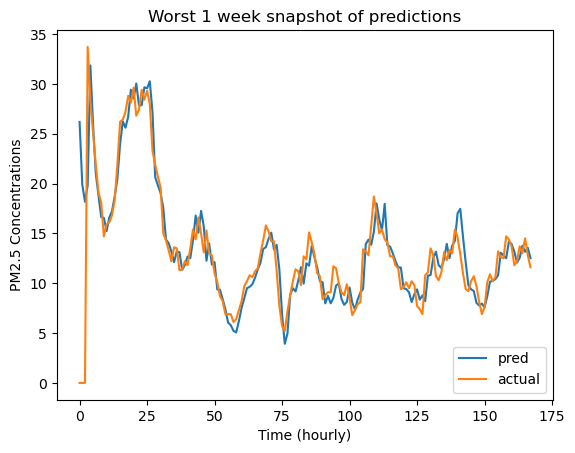

In [24]:
# worst index not cleaned
plt.plot(y_pred[worst_idx:worst_idx+168, 0], label='pred')
plt.plot(Y_test[worst_idx:worst_idx+168, 0], label='actual')
plt.xlabel("Time (hourly)")
plt.ylabel("PM2.5 Concentrations")
plt.title("Worst 1 week snapshot of predictions")
plt.legend(loc="lower right")

## Rolling avg plots

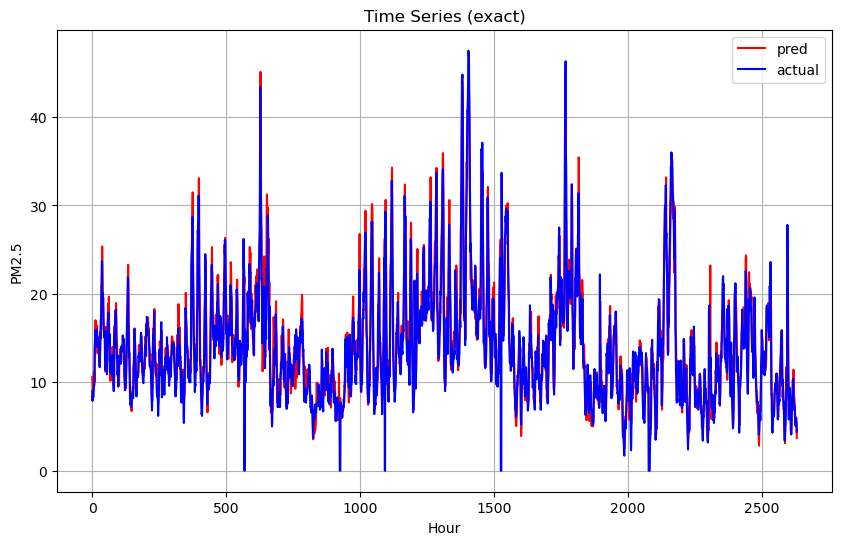

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(y_pred[:, 0], label=f'pred', color='red')
plt.plot(Y_test[:, 0], label=f'actual', color='blue')
plt.title('Time Series (exact)')
plt.xlabel('Hour')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.show()

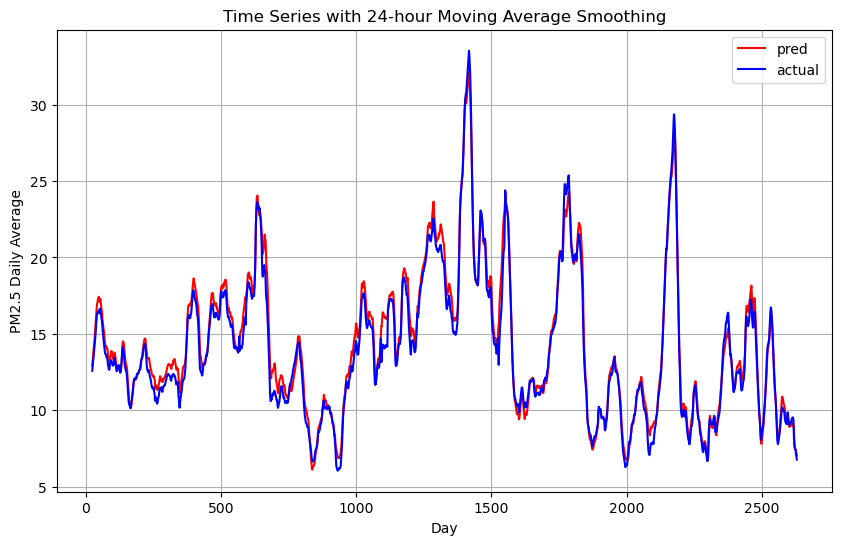

In [26]:
import pandas as pd

series_pred = pd.Series(np.squeeze(y_pred[:, 0]))
series_test = pd.Series(np.squeeze(Y_test[:, 0]))

window_size = 24 # daily average
smoothed_pred = series_pred.rolling(window=window_size).mean()
smoothed_test = series_test.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_pred, label=f'pred', color='red')
plt.plot(smoothed_test, label=f'actual', color='blue')
plt.title('Time Series with 24-hour Moving Average Smoothing')
plt.xlabel('Day')
plt.ylabel('PM2.5 Daily Average')
plt.legend()
plt.grid(True)
plt.show()

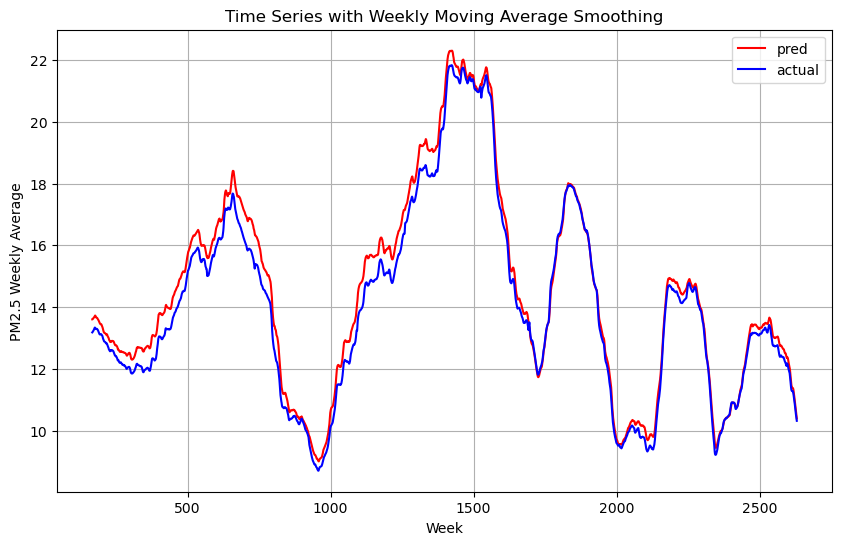

In [27]:
window_size = 168 # weekly average
smoothed_pred = series_pred.rolling(window=window_size).mean()
smoothed_test = series_test.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_pred, label=f'pred', color='red')
plt.plot(smoothed_test, label=f'actual', color='blue')
plt.title('Time Series with Weekly Moving Average Smoothing')
plt.xlabel('Week')
plt.ylabel('PM2.5 Weekly Average')
plt.legend()
plt.grid(True)
plt.show()

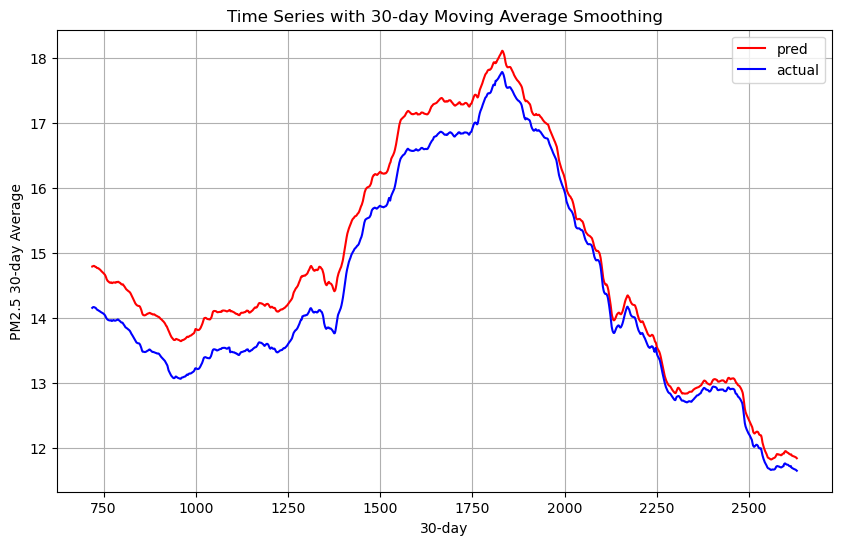

In [28]:
window_size = 720 # weekly average
smoothed_pred = series_pred.rolling(window=window_size).mean()
smoothed_test = series_test.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_pred, label=f'pred', color='red')
plt.plot(smoothed_test, label=f'actual', color='blue')
plt.title('Time Series with 30-day Moving Average Smoothing')
plt.xlabel('30-day')
plt.ylabel('PM2.5 30-day Average')
plt.legend()
plt.grid(True)
plt.show()

## Error plots (first frame)

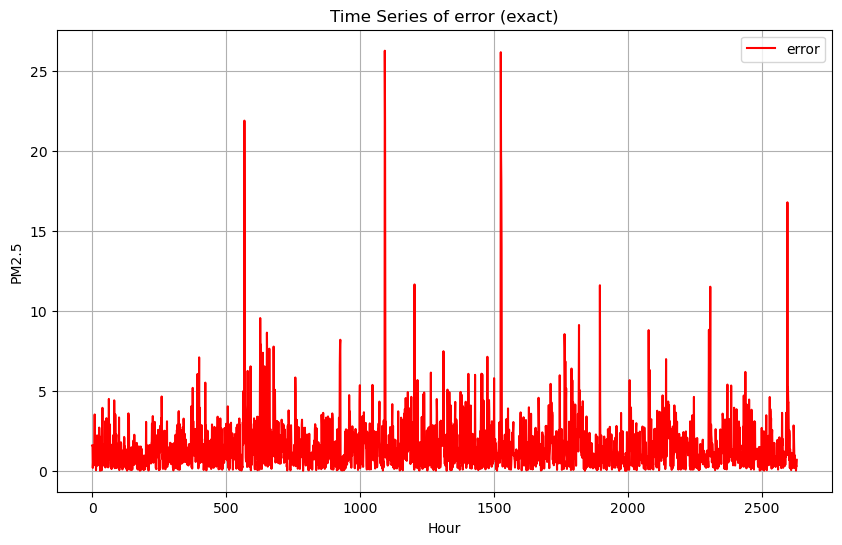

In [29]:
series = pd.Series(np.squeeze(np.abs(y_pred[:, 0] - Y_test[:, 0])))
plt.figure(figsize=(10, 6))
plt.plot(series, label=f'error', color='red')
plt.title('Time Series of error (exact)')
plt.xlabel('Hour')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.show()

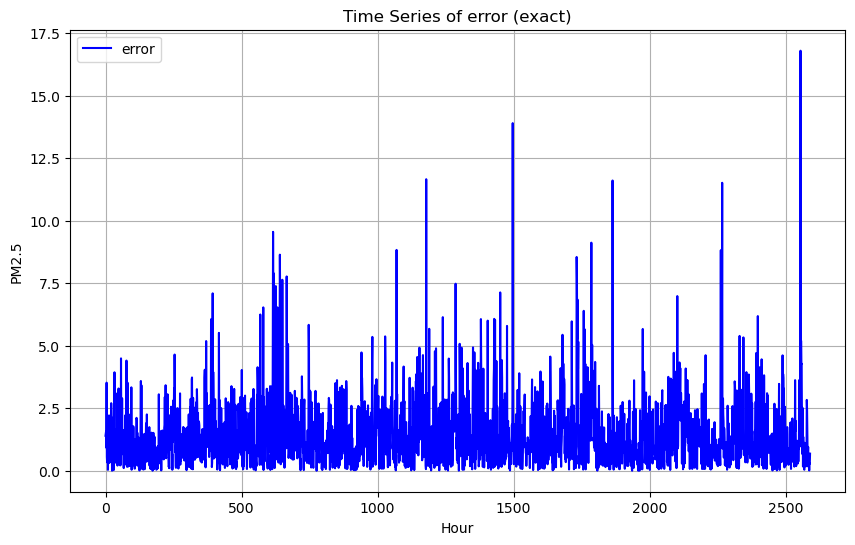

In [32]:
cleaned_series = pd.Series(np.squeeze(np.abs(cleaned_pred[:, 0] - cleaned_test[:, 0])))
plt.figure(figsize=(10, 6))
plt.plot(cleaned_series, label=f'error', color='blue')
plt.title('Time Series of error (exact)')
plt.xlabel('Hour')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.show()

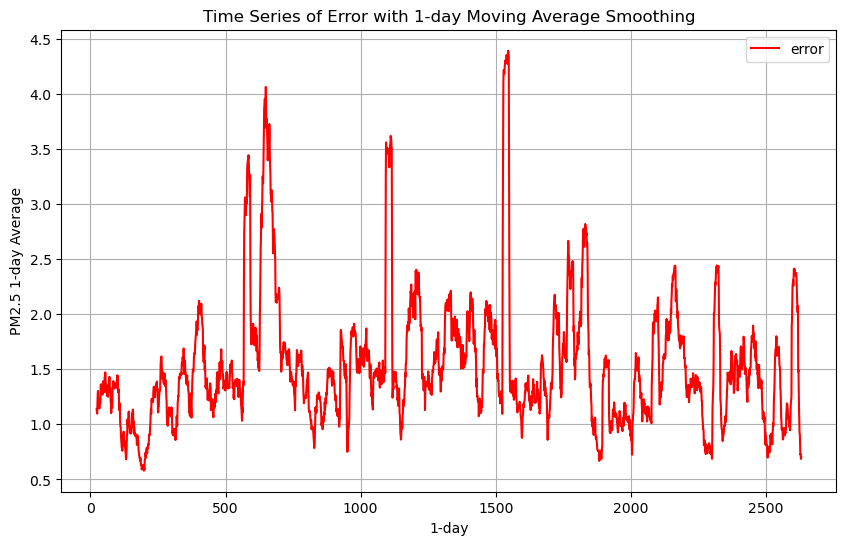

In [33]:
window_size = 24 # weekly average
smoothed_series = series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='red')
plt.title('Time Series of Error with 1-day Moving Average Smoothing')
plt.xlabel('1-day')
plt.ylabel('PM2.5 1-day Average')
plt.legend()
plt.grid(True)
plt.show()

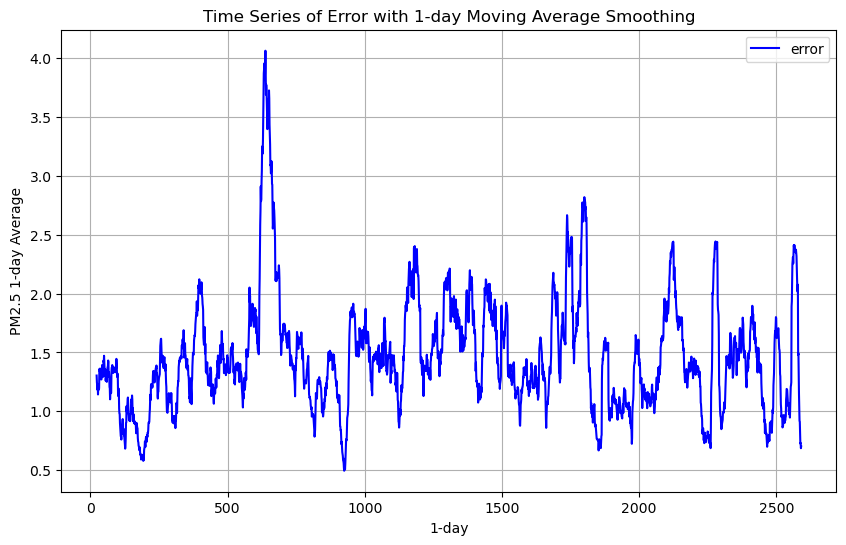

In [34]:
window_size = 24 # weekly average
smoothed_series = cleaned_series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='blue')
plt.title('Time Series of Error with 1-day Moving Average Smoothing')
plt.xlabel('1-day')
plt.ylabel('PM2.5 1-day Average')
plt.legend()
plt.grid(True)
plt.show()

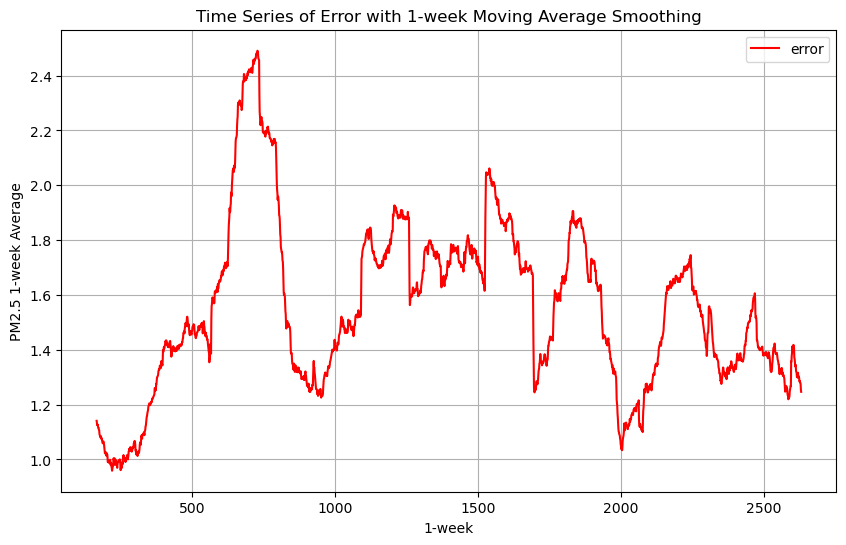

In [35]:
window_size = 168 # weekly average
smoothed_series = series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='red')
plt.title('Time Series of Error with 1-week Moving Average Smoothing')
plt.xlabel('1-week')
plt.ylabel('PM2.5 1-week Average')
plt.legend()
plt.grid(True)
plt.show()

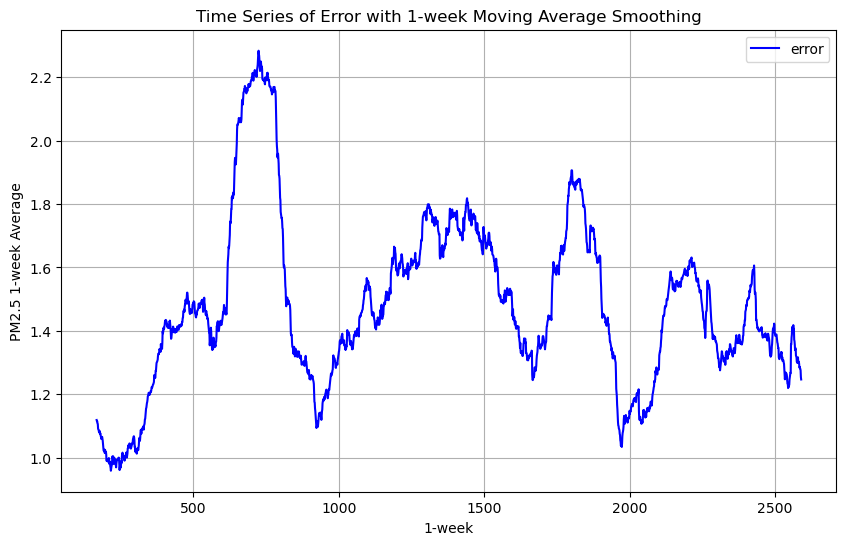

In [36]:
window_size = 168 # weekly average
smoothed_series = cleaned_series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='blue')
plt.title('Time Series of Error with 1-week Moving Average Smoothing')
plt.xlabel('1-week')
plt.ylabel('PM2.5 1-week Average')
plt.legend()
plt.grid(True)
plt.show()

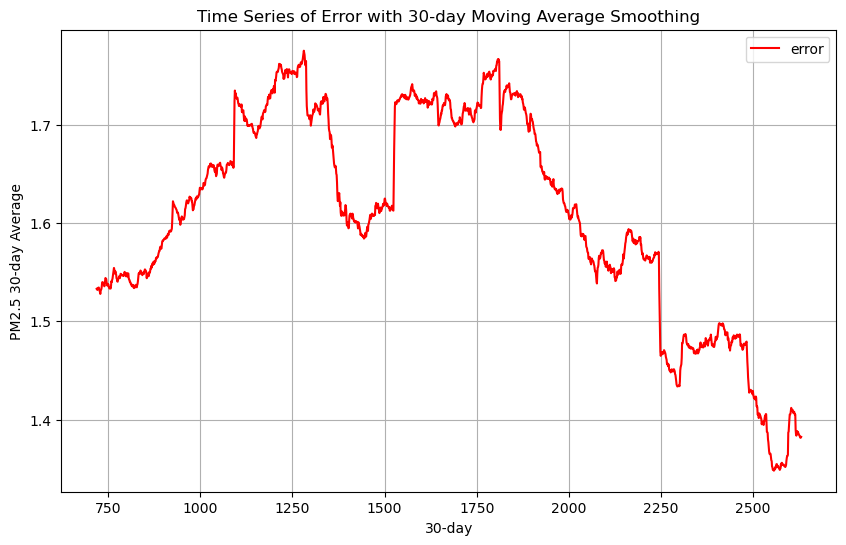

In [37]:
window_size = 720 # 30-day average
smoothed_series = series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='red')
plt.title('Time Series of Error with 30-day Moving Average Smoothing')
plt.xlabel('30-day')
plt.ylabel('PM2.5 30-day Average')
plt.legend()
plt.grid(True)
plt.show()

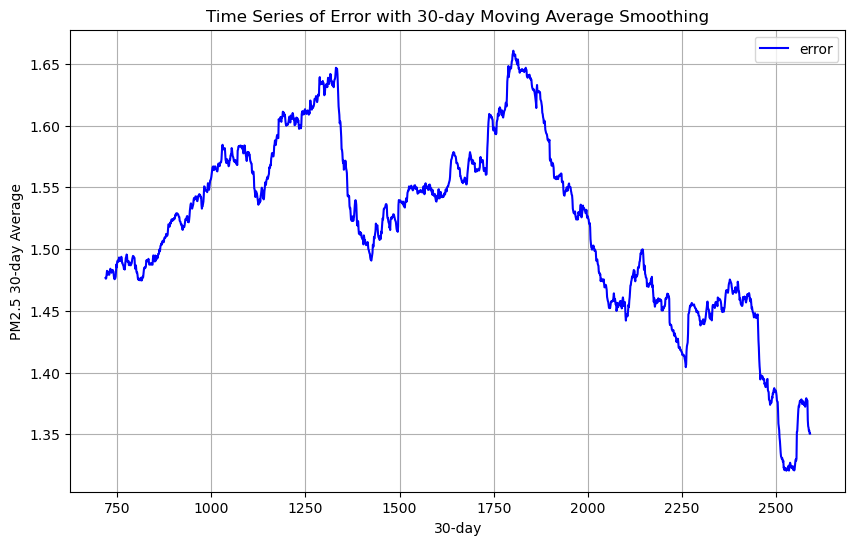

In [38]:
window_size = 720 # 30-day average
smoothed_series = cleaned_series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='blue')
plt.title('Time Series of Error with 30-day Moving Average Smoothing')
plt.xlabel('30-day')
plt.ylabel('PM2.5 30-day Average')
plt.legend()
plt.grid(True)
plt.show()